<a href="https://colab.research.google.com/github/liangchow/soil-type-predictions/blob/main/soil_type_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up Worksheet and Import Libraries

In [2]:
# Clone Gitub repository to Colab
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git
!git clone https://github.com/liangchow/soil-type-predictions.git

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'soil-type-predictions'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 20), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (40/40), 663.97 KiB | 8.62 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
# Acess to soil-type-preidctions folder
%cd /content/soil-type-predictions

# Import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from utils_log import *
from utils_plot import *

/content/soil-type-predictions


In [4]:
# Google Colab GPU
# Check if GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


# Read Data
The dataset should contains the following. There is a total of 126 soil samples:
- ID: Boring ID
- Depth: Depth (ft) the sample was taken
- Sampler: MCS = Modified California Sampler or SPT = Standard Penetration Test
- N1: Known as "set". First set of blowcount counted over first 6 inches of sampler
- N2: The second set of blowcount from 6 to 12 inches of the sampler
- N3: The third set of blowcount from 12 to 18 inches of the sampler
- Soil: Generic soil types "clay" or "sand"
- USCS: USCS soil classification if there is data available

In [5]:
# Read soil data
file_path = "./field_data/soil.csv"
df = pd.read_csv(file_path)
df

,ID,Depth,Sampler,N1,N2,N3,Soil,UCSC
0,B-1,15.0,MCS,0.0,0.0,0.0,Clay,CL
1,B-1,20.0,MCS,0.0,0.0,0.0,Clay,CL
2,B-1,75.0,SPT,0.0,3.0,2.0,Clay,CH
3,B-1,100.0,SPT,24.0,19.0,20.0,Clay,CL
4,B-2,10.5,MCS,0.0,0.0,0.0,Clay,CL
...,...,...,...,...,...,...,...,...
121,AB-4,25.0,SPT,6.0,9.0,16.0,Sand,ML
122,AB-4,35.0,SPT,25.0,35.0,39.0,Sand,SC
123,AB-4,40.0,SPT,16.0,28.0,25.0,Sand,SC
124,AB-4,45.0,SPT,8.0,11.0,20.0,Sand,SC


# Data Pre-Processing
Before we visualize the data, we will have to convert the blowcount to equivalent "SPT" blowcount, then compute both SPT-N and take a difference between SPT-N and the "set". After we are done with that, we will create a "Class" column to categorize Sand as "1" and Clay as "0".
- By definition, SPT-N is the summation of SPT blowcount from 6 to 18 inches, i.e., N2 + N3 for the SPT sampler. Blowcount from the first 6 inches of sampler or "set" is considered as distrubed, and generally disregarded. We don't have to convert the blowcount obtain using the SPT sampler. However, for Modified California Sampler (MCS), a coverstion factor of 0.68 based on the area ratio is applied to the blowcount to get equivalent SPT-N.  
- After conversion to SPT blowcounts, we simply add the SPT blowcounts from the second and third sets to get "SPT-N". Then, we will add one more column to take a difference between SPT-N and SPT blowcount from the "set".  
- For simplicity, we will only group the soil type into two classes: Sand (y=1) and Clay (y=0). We will not use the USCS classifications in this exercise.

In [6]:
# Create a function to convert each blowcount (N1, N2, and N3) to equivalent SPT-N
def equiv_SPT_N(sampler, n_val):

  if sampler == "MCS":
    return 0.68*n_val
  else:
    return n_val

# Create a function to categorize Sand and Clay
def categorize_soil(soil):
  if soil == "Sand":
    return 1
  else:
    return 0

In [13]:
X = pd.DataFrame(df["Depth"])
X["Class"] = df["Soil"].apply(lambda x: categorize_soil(x))

# Apply functions to the dataframe().
X["SPT_N1"] = df.apply(lambda x: equiv_SPT_N(x["Sampler"], x["N1"]), axis=1)
X["SPT_N2"] = df.apply(lambda x: equiv_SPT_N(x["Sampler"], x["N2"]), axis=1)
X["SPT_N3"] = df.apply(lambda x: equiv_SPT_N(x["Sampler"], x["N3"]), axis=1)
X["SPT_N"] = df["SPT_N2"] + df["SPT_N3"]
X["SPT_N_diff"] = X["SPT_N"] - X["SPT_N1"]

X

,Depth,Class,SPT_N1,SPT_N2,SPT_N3,SPT_N,SPT_N_diff
0,15.0,0,0.0,0.0,0.0,0.0,0.0
1,20.0,0,0.0,0.0,0.0,0.0,0.0
2,75.0,0,0.0,3.0,2.0,5.0,5.0
3,100.0,0,24.0,19.0,20.0,39.0,15.0
4,10.5,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
121,25.0,1,6.0,9.0,16.0,25.0,19.0
122,35.0,1,25.0,35.0,39.0,74.0,49.0
123,40.0,1,16.0,28.0,25.0,53.0,37.0
124,45.0,1,8.0,11.0,20.0,31.0,23.0


# Data Visualization
Let's take a look at the data: The upper plot is for Clay (y=0) and the lower is for Sand (y=1). When SPT-N is plotted against depths, we see two clusters of data. Clay data points tend to skew toward lower blowcount, while Sand data points spread across the range from 0 to 200. This is great because we can draw a boundary line between these two clusters.

Class
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
dtype: object

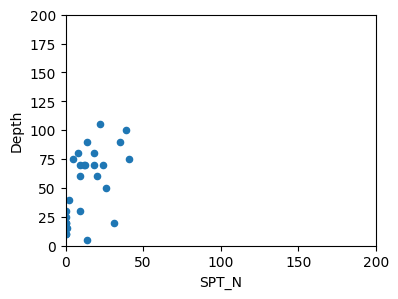

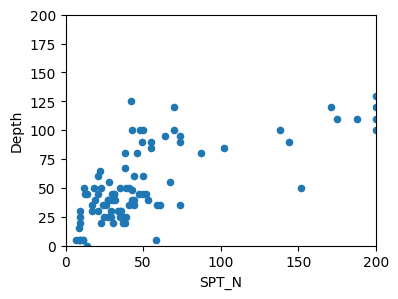

In [15]:
# Plotting two classes: Clay and Sand
X.groupby("Class").plot(kind='scatter', x='SPT_N', y='Depth', xlim=(0, 200), ylim=(0,200), figsize=(4,3))

# Data Processing

In [ ]:
# Separate data into X_train and y_train
X_train = df[["Depth", "SPT-N"]]
y_train = df["Class"]